In [48]:
# @title Running in Colab

from IPython.display import HTML, Javascript, display

display(
    HTML(
        """<a href="https://colab.research.google.com/github/evan-lloyd/mechinterp-experiments/blob/main/tiny_stories_sae/e2e_demo.ipynb" target="_blank" id="colab-button">
            Run this notebook in Google Colab
        </a>"""
    )
)
display(
    Javascript("""
        setTimeout(() => {
            if(typeof google.colab != "undefined") {
                document.querySelector("#colab-button").remove()
            }
        }, 0);
        """)
)

<IPython.core.display.Javascript object>

# Initialize notebook environment


In [49]:
import os

# If we're running in Colab, we need to clone the non-notebook source from git.
if os.getenv("COLAB_RELEASE_TAG") and not os.path.isdir(
    "/content/mechinterp-experiments"
):
    ip = get_ipython()  #  pyright: ignore[reportUndefinedVariable]
    ip.run_cell_magic(
        "bash",
        "",
        """
    git clone --filter=blob:none --no-checkout https://github.com/evan-lloyd/mechinterp-experiments.git
    cd mechinterp-experiments
    git sparse-checkout init --no-cone
    echo "/tiny_stories_sae" > .git/info/sparse-checkout
    git checkout
  """,
    )
    ip.run_line_magic("cd", "mechinterp-experiments/tiny_stories_sae")
else:
    print("Already cloned source, or not running in Colab.")

# Nice for dev, but not needed for Colab.
try:
    # This uses a library called jurigged to hot-reload code when it is changed.
    # For reasons I've never been able to figure out, the IPython %autoreload magic
    # completely fails to work with the kind of structure I use in this notebook.
    import tiny_stories_sae._autoreload
except Exception:
    pass

Already cloned source, or not running in Colab.


In [50]:
import torch
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer

# Tweak TRAINING_BATCH_SIZE for your hardware if necessary
if torch.cuda.is_available():
    TRAINING_DEVICE = "cuda"
    TRAINING_BATCH_SIZE = 16
    E2E_BATCH_SIZE = 4
elif torch.mps.is_available():
    TRAINING_DEVICE = "mps"
    TRAINING_BATCH_SIZE = 8
    E2E_BATCH_SIZE = 2
else:
    TRAINING_DEVICE = "cpu"
    TRAINING_BATCH_SIZE = 8
    E2E_BATCH_SIZE = 2

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
training_dataset = load_dataset("roneneldan/TinyStories", split="train", streaming=True)
validation_dataset = load_dataset(
    "roneneldan/TinyStories", split="validation", streaming=True
)
model = AutoModelForCausalLM.from_pretrained("roneneldan/TinyStories-33M").to(
    TRAINING_DEVICE
)

print(model)

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-3): 4 x GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_feat

In [51]:
# Caches model activations to these directories; modify if necessary, or set to None to disable.
# These take up ~16GB and ~1.5GB respectively, but will save a fair bit of time when running
# the notebook, since they can be re-used across all methods we're comparing.
TRAINING_CACHE_DIR = None
VALIDATION_CACHE_DIR = None
# TRAINING_CACHE_DIR = ".training_cache"
# VALIDATION_CACHE_DIR = ".validation_cache"
NUM_TRAINING_TOKENS = int(1e5)
EVAL_INTERVAL = int(1e4)
NUM_VALIDATION_TOKENS = int(1e5)
D_MODEL = model.config.hidden_size
D_SAE = D_MODEL * 4
TOKENIZER_BATCH_SIZE = 128

# Train SAEs for comparison


In [52]:
from tiny_stories_sae.sae import SAE
from tiny_stories_sae.training import TrainingConfig, TrainingMethod, train

saes = {
    method: {
        layer: SAE(
            D_MODEL,
            D_SAE,
            device=model.device,
            kind="topk",
            topk=100,
        )
        for layer in range(model.config.num_layers)
    }
    for method in TrainingMethod
}


def linear_decay(frac_trained: float):
    return 1.0 - frac_trained


training_config = {
    method: TrainingConfig(
        tokenizer_batch_size=TOKENIZER_BATCH_SIZE,
        training_batch_size=TRAINING_BATCH_SIZE,
        e2e_batch_size=E2E_BATCH_SIZE,
        num_train_tokens=NUM_TRAINING_TOKENS,
        eval_interval=EVAL_INTERVAL,
        train_layers=list(range(model.config.num_layers)),
        lr=1e-3,
        finetune_lr_schedule=linear_decay,  # per Karvonen (2025)
        use_downstream_saes=method is TrainingMethod.next_layer,
        downstream_reconstruction_weight=1.0
        if method is TrainingMethod.next_layer
        else 0.0,
        reconstruction_weight=1.0,
        balance_reconstruction_losses=method is TrainingMethod.next_layer,
        method=method,
        finetune_fraction=0.10 if method is TrainingMethod.finetuned else None,
        # Currently unused training tweaks, to be explored in a future blog post!
        dense_weight=0.0,
        idempotency_weight=0.0,
        use_weighted_mask=False,
    )
    for method in TrainingMethod
}

training_results = {}

In [53]:
from tiny_stories_sae.sae_data import get_sae_data_with_replacement
from tiny_stories_sae.tokenization import input_generator
from tiny_stories_sae.replacement_model import make_replacement_model

for step, batch in enumerate(
    input_generator(
        model,
        tokenizer,
        training_dataset,
        max_tokens=1000,
        tokenizer_batch_size=100,
        inference_batch_size=2,
        use_weighted_mask=False,
    )
):
    print(get_sae_data_with_replacement(
        model,
        make_replacement_model(model, saes[TrainingMethod.full]),
        saes[TrainingMethod.full],
        batch,
        start_layer=2,
        # cache_dir=".training_cache",
        # cache_offset=0,
    )[1])

{2: SAEData(target_layer=2, original=tensor([[[-0.6513,  0.0053, -1.8396,  ..., -0.5094,  0.3330,  0.0167],
         [-0.2082, -0.3000, -1.3324,  ..., -1.2003, -0.3023, -0.2184],
         [-0.3377,  0.1467, -0.2630,  ..., -0.9879, -0.1699, -0.0118],
         ...,
         [ 0.3835, -0.0807, -0.5963,  ..., -0.3594,  0.3811, -0.0381],
         [ 0.3844, -0.0817, -0.5967,  ..., -0.3595,  0.3828, -0.0349],
         [ 0.3862, -0.0829, -0.6003,  ..., -0.3593,  0.3854, -0.0345]],

        [[-0.6513,  0.0053, -1.8396,  ..., -0.5094,  0.3330,  0.0167],
         [-0.2082, -0.3000, -1.3324,  ..., -1.2003, -0.3023, -0.2184],
         [-0.3377,  0.1467, -0.2630,  ..., -0.9879, -0.1699, -0.0118],
         ...,
         [ 0.4008,  0.0053, -0.6563,  ..., -0.6350,  0.2902,  0.1296],
         [ 0.4016,  0.0058, -0.6575,  ..., -0.6351,  0.2921,  0.1307],
         [ 0.4029,  0.0055, -0.6574,  ..., -0.6345,  0.2945,  0.1332]]],
       device='mps:0', grad_fn=<AddBackward0>), normalized_original=tensor([[[-

In [54]:
import os

from tiny_stories_sae.training import build_cache

if TRAINING_CACHE_DIR and (
    not os.path.exists(TRAINING_CACHE_DIR) or not os.listdir(TRAINING_CACHE_DIR)
):
    build_cache(
        TRAINING_CACHE_DIR,
        model,
        tokenizer,
        training_dataset,
        tokenizer_batch_size=TOKENIZER_BATCH_SIZE,
        inference_batch_size=TRAINING_BATCH_SIZE,
        num_tokens=NUM_TRAINING_TOKENS,
    )

if VALIDATION_CACHE_DIR and (
    not os.path.exists(VALIDATION_CACHE_DIR) or not os.listdir(VALIDATION_CACHE_DIR)
):
    build_cache(
        VALIDATION_CACHE_DIR,
        model,
        tokenizer,
        validation_dataset,
        tokenizer_batch_size=TOKENIZER_BATCH_SIZE,
        inference_batch_size=TRAINING_BATCH_SIZE,
        num_tokens=NUM_VALIDATION_TOKENS,
    )

# Standard loss (current layer reconstruction error only)

In [55]:
training_results[TrainingMethod.standard] = train(
    model,
    tokenizer,
    saes[TrainingMethod.standard],
    training_dataset,
    training_config[TrainingMethod.standard],
    cache_dir=TRAINING_CACHE_DIR,
    reinit_weights=True,
)

Layer 3

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 2

  0%|          | 0/100000 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Full replacement model training (my method)

In [67]:
training_results[TrainingMethod.full] = train(
    model,
    tokenizer,
    saes[TrainingMethod.full],
    training_dataset,
    training_config[TrainingMethod.full],
    cache_dir=TRAINING_CACHE_DIR,
    reinit_weights=True,
)

Layer 3

Layer 2

Layer 1

Layer 0

  0%|          | 0/100000 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/Users/evanlloyd/mechinterp-experiments/tiny_stories_sae/.venv/lib/python3.12/site-packages/jurigged/codetools.py", line 533, in _process_child_correspondence
    orig.apply_correspondence(
  File "/Users/evanlloyd/mechinterp-experiments/tiny_stories_sae/.venv/lib/python3.12/site-packages/jurigged/codetools.py", line 747, in apply_correspondence
    self.recode(new_code, recode_current=False)
  File "/Users/evanlloyd/mechinterp-experiments/tiny_stories_sae/.venv/lib/python3.12/site-packages/jurigged/codetools.py", line 735, in recode
    conform(co, subcode, use_cache=use_cache)
  File "/Users/evanlloyd/mechinterp-experiments/tiny_stories_sae/.venv/lib/python3.12/site-packages/codefind/registry.py", line 144, in conform
    fv1 = obj1.__code__.co_freevars
          ^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute '__code__'. Did you mean: '__bool__'?

Traceback (most recent call last):
  File "/Users/evanlloyd/mechinterp-experi

## Next-layer auxiliary loss (my method)


In [63]:
training_results[TrainingMethod.next_layer] = train(
    model,
    tokenizer,
    saes[TrainingMethod.next_layer],
    training_dataset,
    training_config[TrainingMethod.next_layer],
    cache_dir=TRAINING_CACHE_DIR,
    reinit_weights=True,
)

Layer 3

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 2

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 1

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 0

  0%|          | 0/100000 [00:00<?, ?it/s]

## End-to-end training

Recreation of the method SAE_e2e+ds from

> Braun, Dan, Jordan Taylor, Nicholas Goldowsky-Dill, and Lee Sharkey. 2024. “Identifying Functionally Important Features with End-to-End Sparse Dictionary Learning.” arXiv [Cs.LG]. arXiv. http://arxiv.org/abs/2405.12241.


In [64]:
training_results[TrainingMethod.e2e] = train(
    model,
    tokenizer,
    saes[TrainingMethod.e2e],
    training_dataset,
    training_config[TrainingMethod.e2e],
    cache_dir=TRAINING_CACHE_DIR,
    reinit_weights=True,
)

Layer 3

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 2

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 1

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 0

  0%|          | 0/100000 [00:00<?, ?it/s]

## KL fine-tuning

Recreation of the KL fine-tuning method from

> Karvonen, Adam. 2025. “Revisiting End-to-End Sparse Autoencoder Training: A Short Finetune Is All You Need.” arXiv [Cs.LG]. arXiv. http://arxiv.org/abs/2503.17272.


In [10]:
training_results[TrainingMethod.finetuned] = train(
    model,
    tokenizer,
    saes[TrainingMethod.finetuned],
    training_dataset,
    training_config[TrainingMethod.finetuned],
    cache_dir=TRAINING_CACHE_DIR,
    reinit_weights=True,
)

Layer 3

  0%|          | 0/9000000 [00:00<?, ?it/s]

Layer 2

  0%|          | 0/9000000 [00:00<?, ?it/s]

Layer 1

  0%|          | 0/9000000 [00:00<?, ?it/s]

Layer 0

  0%|          | 0/9000000 [00:00<?, ?it/s]

Layer 3

  0%|          | 0/994735 [00:00<?, ?it/s]

Layer 2

  0%|          | 0/994735 [00:00<?, ?it/s]

Layer 1

  0%|          | 0/994735 [00:00<?, ?it/s]

Layer 0

  0%|          | 0/994735 [00:00<?, ?it/s]

# Evaluations and comparisons


## Train-time evaluations

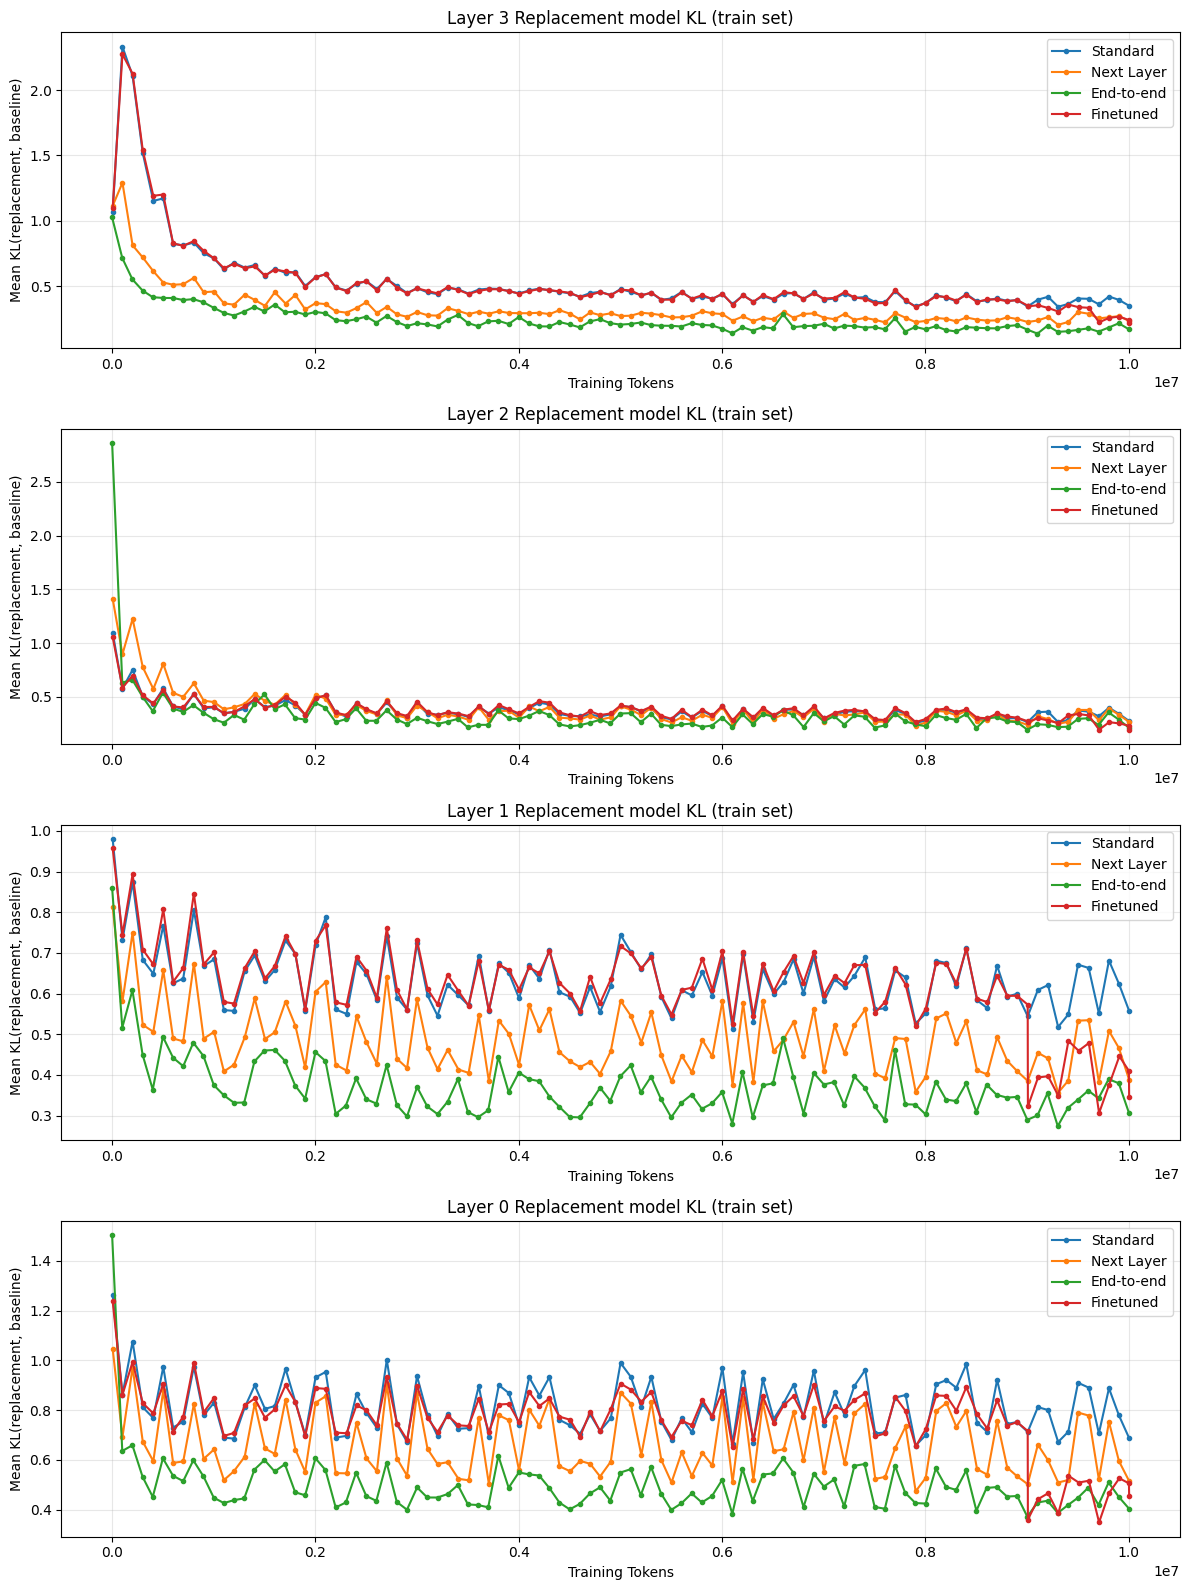

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(model.config.num_layers, 1, figsize=(12, 4 * model.config.num_layers))

for i, layer in enumerate(range(model.config.num_layers - 1, -1, -1)):
    ax = axes[i]
    
    for method in training_results:
        data = training_results[method][layer]['rep_kl']
        if data:
            tokens, kl_values = zip(*data)
            ax.plot(tokens, kl_values, label=method.value, marker='o', markersize=3)

    ax.set_xlabel('Training Tokens')
    ax.set_ylabel('Mean KL(replacement, baseline)')
    ax.set_title(f'Layer {layer} Replacement model KL (train set)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


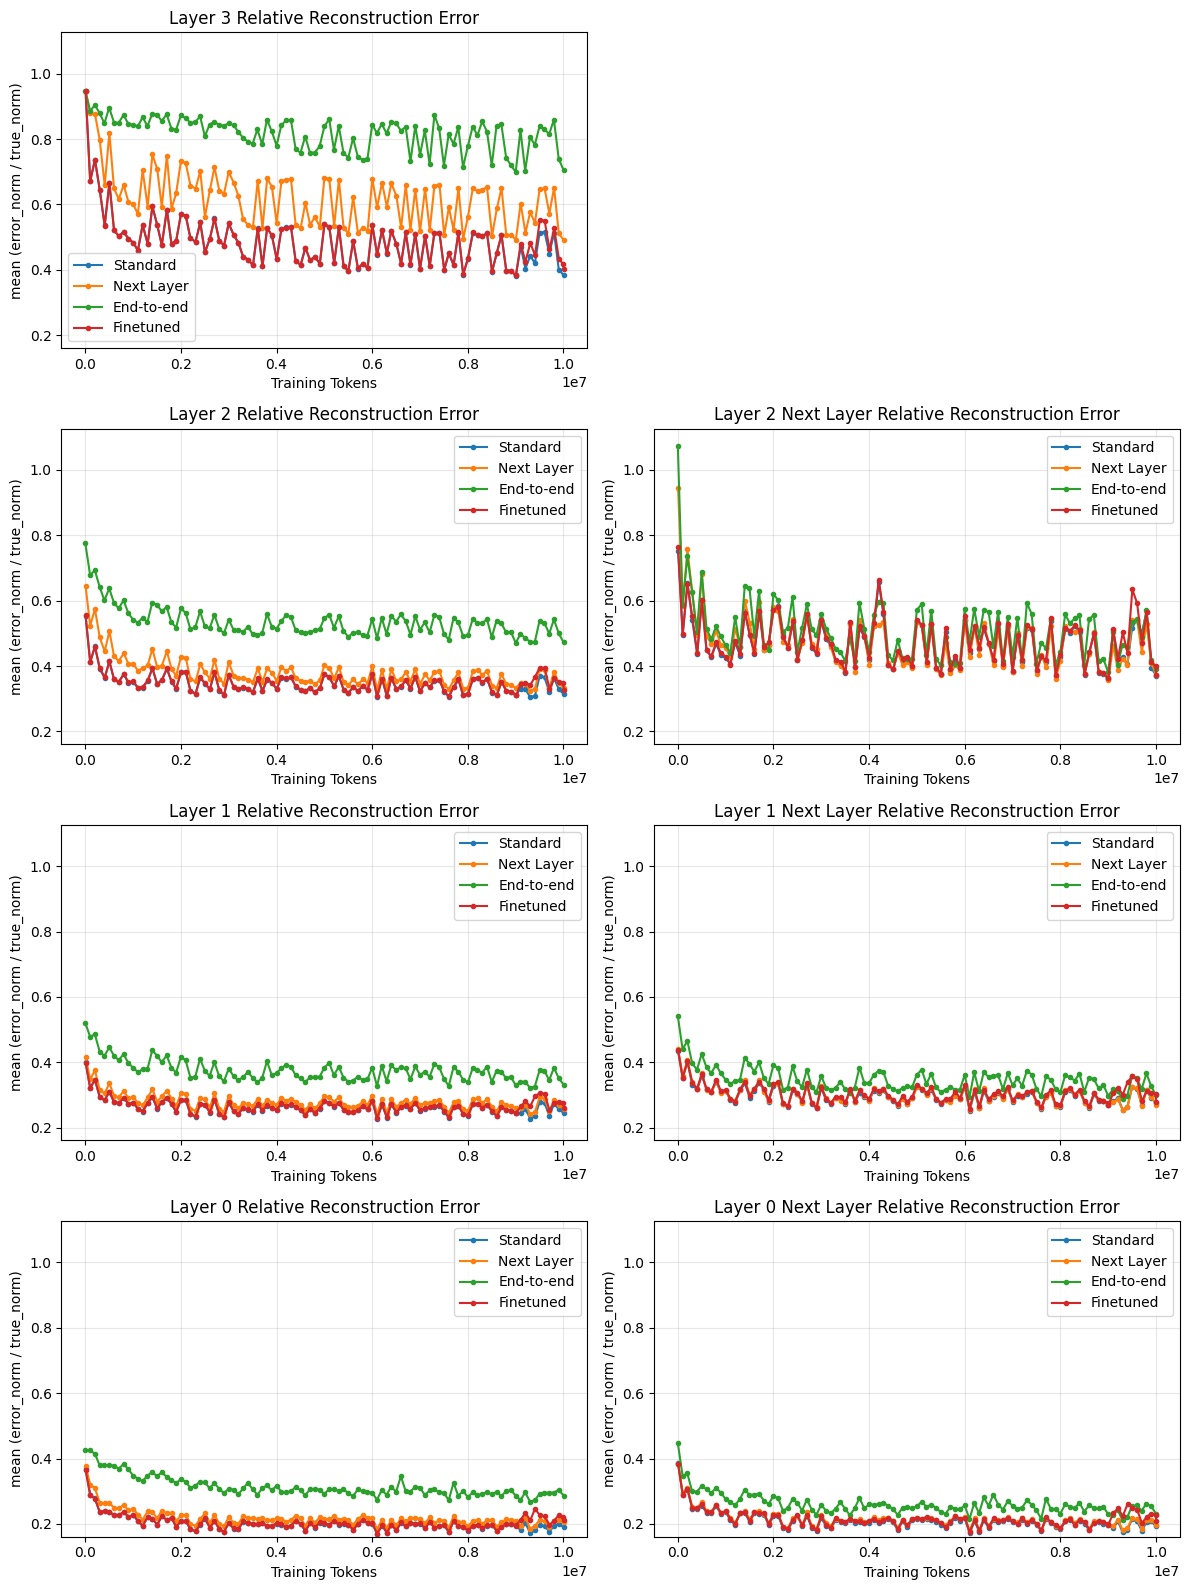

In [12]:
fig, axes = plt.subplots(model.config.num_layers, 2, figsize=(12, 4 * model.config.num_layers))

# Collect all rcn and next_rcn values to determine consistent y-axis limits
all_rcn_values = []
all_next_rcn_values = []

for layer in range(model.config.num_layers):
    for method in training_results:
        # Collect rcn values
        rcn_data = training_results[method][layer]['rcn']
        if rcn_data:
            _, rcn_values = zip(*rcn_data)
            all_rcn_values.extend(rcn_values)
        
        # Collect next_rcn values
        if layer < model.config.num_layers - 1:
            next_rcn_data = training_results[method][layer]['next_rcn']
            if next_rcn_data:
                _, next_rcn_values = zip(*next_rcn_data)
                all_next_rcn_values.extend(next_rcn_values)

# Calculate consistent y-axis limits for both rcn and next_rcn
all_values = all_rcn_values + all_next_rcn_values
y_min, y_max = min(all_values), max(all_values)

for i, layer in enumerate(range(model.config.num_layers - 1, -1, -1)):
    # Plot rcn (relative reconstruction norm)
    ax1 = axes[i, 0]
    for method in training_results:
        data = training_results[method][layer]['rcn']
        if data:
            tokens, rcn_values = zip(*data)
            ax1.plot(tokens, rcn_values, label=method.value, marker='o', markersize=3)

    ax1.set_xlabel('Training Tokens')
    ax1.set_ylabel('mean (error_norm / true_norm)')
    ax1.set_title(f'Layer {layer} Relative Reconstruction Error')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(y_min * 0.95, y_max * 1.05)

    # Plot next_rcn (next layer relative reconstruction norm)
    if layer < model.config.num_layers - 1:
        ax2 = axes[i, 1]
        for method in training_results:
            data = training_results[method][layer]['next_rcn']
            if data:
                tokens, next_rcn_values = zip(*data)
                ax2.plot(tokens, next_rcn_values, label=method.value, marker='o', markersize=3)

        ax2.set_xlabel('Training Tokens')
        ax2.set_ylabel('mean (error_norm / true_norm)')
        ax2.set_title(f'Layer {layer} Next Layer Relative Reconstruction Error')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(y_min * 0.95, y_max * 1.05)
    else:
        axes[i, 1].set_visible(False)

plt.tight_layout()
plt.show()


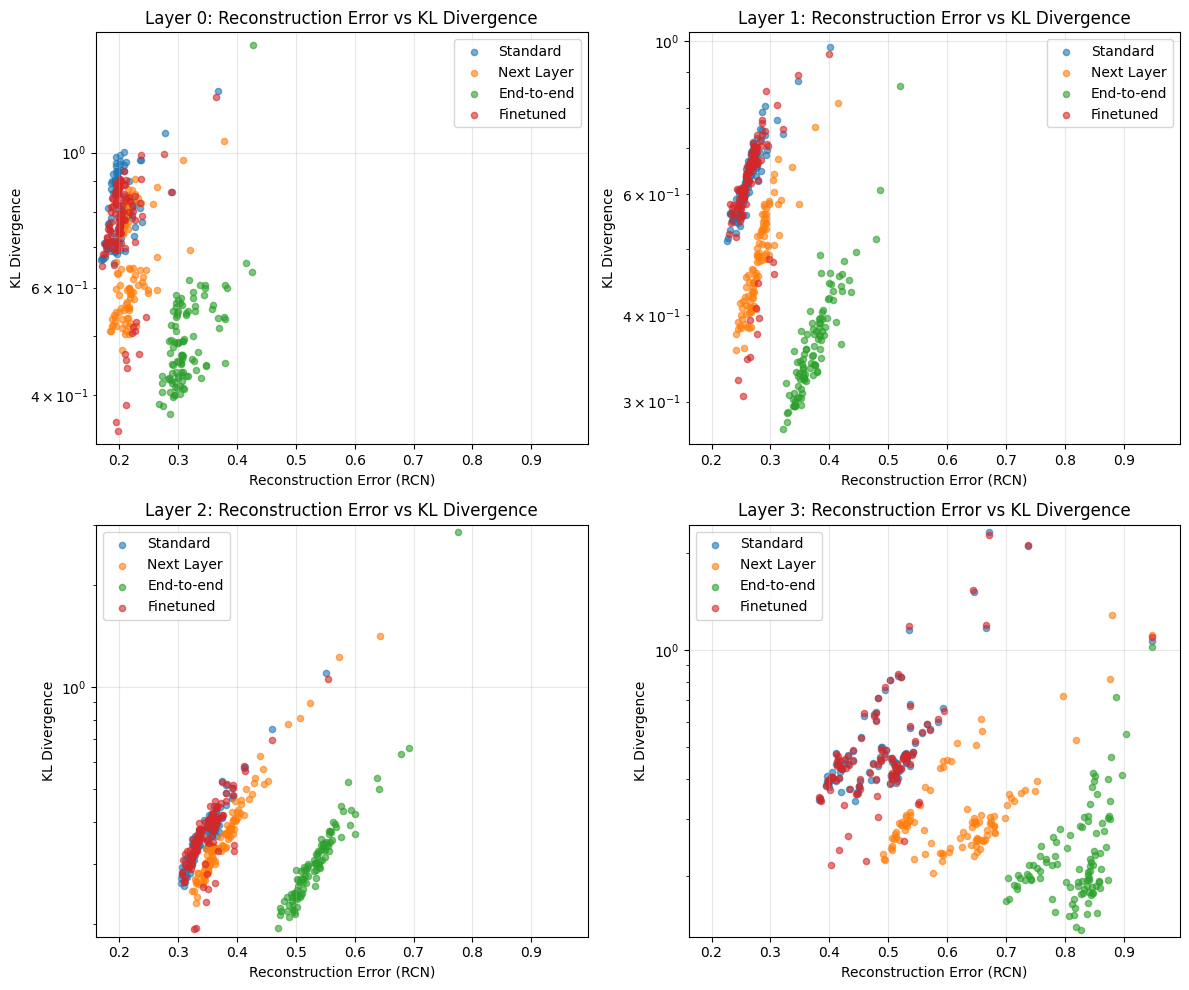

In [24]:
# Plot reconstruction error vs KL divergence for each layer separately
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Collect all RCN values across all layers and methods to determine global x-axis limits
all_rcn_values = []
for layer in range(model.config.num_layers):
    for method in training_results.keys():
        rcn_data = training_results[method][layer]['rcn']
        _, rcn_values = zip(*rcn_data)
        all_rcn_values.extend(rcn_values)

# Calculate global x-axis limits
global_rcn_min, global_rcn_max = min(all_rcn_values), max(all_rcn_values)

for layer in range(model.config.num_layers):
    ax = axes[layer]
    
    # Collect all KL values for this layer to determine y-axis limits
    layer_kl_values = []
    for method in training_results.keys():
        kl_data = training_results[method][layer]['rep_kl']
        _, kl_values = zip(*kl_data)
        layer_kl_values.extend(kl_values)
    
    # Calculate layer-specific y-axis limits
    kl_min, kl_max = min(layer_kl_values), max(layer_kl_values)
    
    for method in training_results.keys():
        # Get reconstruction error (rcn) and KL divergence for this layer
        rcn_data = training_results[method][layer]['rcn']
        kl_data = training_results[method][layer]['rep_kl']
        
        # Extract values from the (tokens, value) tuples
        _, rcn_values = zip(*rcn_data)
        _, kl_values = zip(*kl_data)
        
        # Create scatter plot
        ax.scatter(rcn_values, kl_values, alpha=0.6, s=20, 
                  label=f'{method.value}')

    ax.set_xlabel('Reconstruction Error (RCN)')
    ax.set_ylabel('KL Divergence')
    ax.set_title(f'Layer {layer}: Reconstruction Error vs KL Divergence')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Set consistent x-axis limits across all layers, layer-specific y-axis limits
    ax.set_xlim(global_rcn_min * 0.95, global_rcn_max * 1.05)
    ax.set_ylim(kl_min * 0.95, kl_max * 1.05)

    # Set log scale for better visualization
    ax.set_yscale('log')

plt.tight_layout()
plt.show()



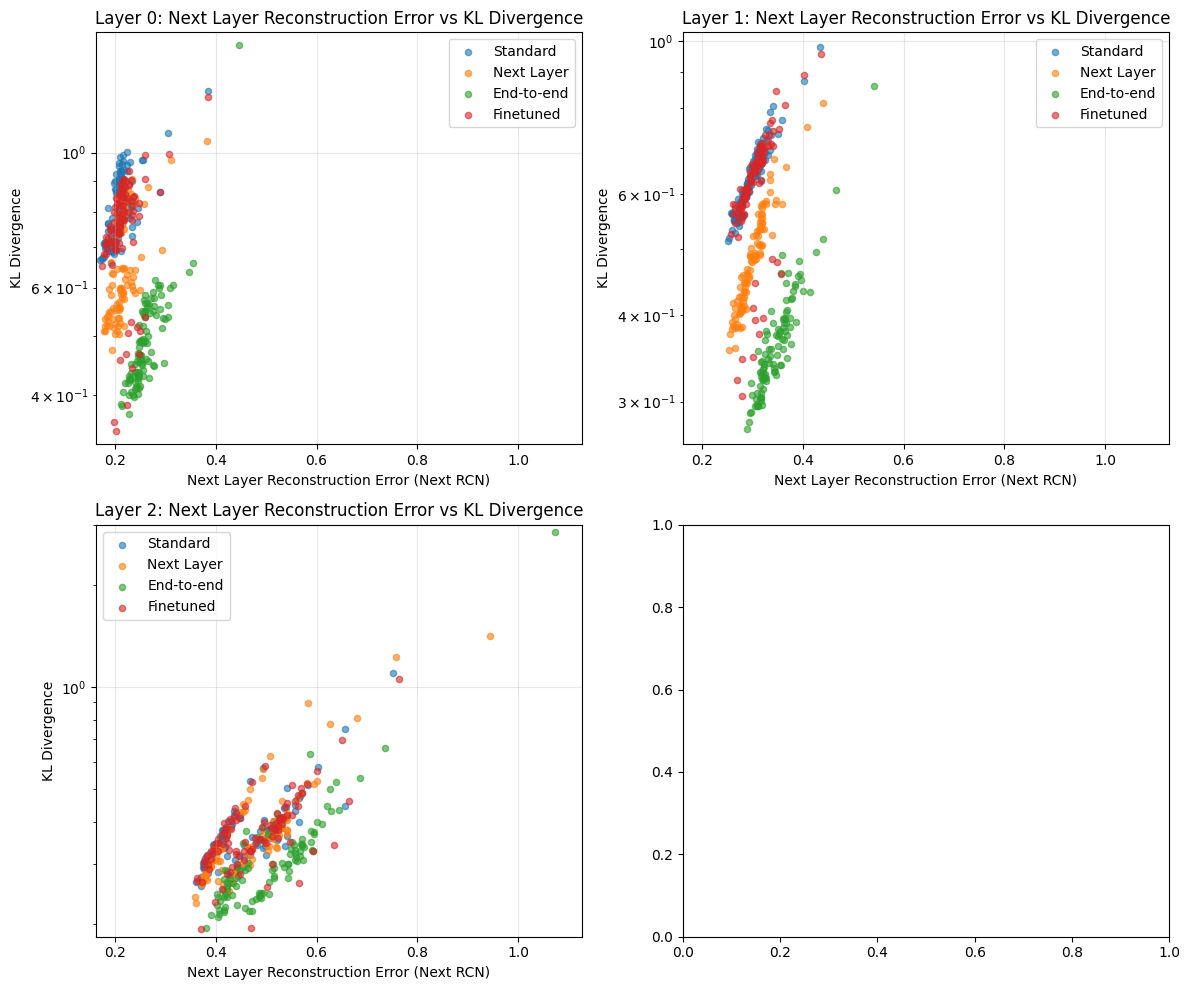

In [25]:
# Plot next_rcn vs KL divergence for each layer (skip final layer)
layers_to_plot = [layer for layer in training_results[list(training_results.keys())[0]].keys() if layer < max(training_results[list(training_results.keys())[0]].keys())]
num_layers = len(layers_to_plot)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Calculate global x-axis limits across all layers
all_next_rcn_values = []
for layer in layers_to_plot:
    for method in training_results.keys():
        next_rcn_data = training_results[method][layer]['next_rcn']
        _, next_rcn_values = zip(*next_rcn_data)
        all_next_rcn_values.extend(next_rcn_values)

global_next_rcn_min, global_next_rcn_max = min(all_next_rcn_values), max(all_next_rcn_values)

for i, layer in enumerate(layers_to_plot):
    ax = axes[i]
    
    # Collect all KL values for this layer to determine y-axis limits
    layer_kl_values = []
    for method in training_results.keys():
        kl_data = training_results[method][layer]['rep_kl']
        _, kl_values = zip(*kl_data)
        layer_kl_values.extend(kl_values)
    
    # Calculate layer-specific y-axis limits
    kl_min, kl_max = min(layer_kl_values), max(layer_kl_values)
    
    for method in training_results.keys():
        # Get next layer reconstruction error (next_rcn) and KL divergence for this layer
        next_rcn_data = training_results[method][layer]['next_rcn']
        kl_data = training_results[method][layer]['rep_kl']
        
        # Extract values from the (tokens, value) tuples
        _, next_rcn_values = zip(*next_rcn_data)
        _, kl_values = zip(*kl_data)
        
        # Create scatter plot
        ax.scatter(next_rcn_values, kl_values, alpha=0.6, s=20, 
                  label=f'{method.value}')

    ax.set_xlabel('Next Layer Reconstruction Error (Next RCN)')
    ax.set_ylabel('KL Divergence')
    ax.set_title(f'Layer {layer}: Next Layer Reconstruction Error vs KL Divergence')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Set consistent x-axis limits across all layers, layer-specific y-axis limits
    ax.set_xlim(global_next_rcn_min * 0.95, global_next_rcn_max * 1.05)
    ax.set_ylim(kl_min * 0.95, kl_max * 1.05)

    # Set log scale for better visualization
    ax.set_yscale('log')

plt.tight_layout()
plt.show()


## Validation set evals

In [10]:
from tiny_stories_sae.validation import validate_saes

validation_evals = {}
replacement_evals = {}
position_ids = {}
for method in training_results.keys():
    validation_evals[method], replacement_evals[method], position_ids[method] = (
        validate_saes(
            model,
            tokenizer,
            saes[method],
            validation_dataset,
            num_tokens=NUM_VALIDATION_TOKENS,
            tokenizer_batch_size=training_config[method].tokenizer_batch_size,
            inference_batch_size=training_config[method].training_batch_size,
            cache_dir=VALIDATION_CACHE_DIR,
        )
    )

Running SAE evals:   0%|          | 0/100000 [00:00<?, ?it/s]

Running SAE evals:   0%|          | 0/100000 [00:00<?, ?it/s]

Running SAE evals:   0%|          | 0/100000 [00:00<?, ?it/s]

Running SAE evals:   0%|          | 0/100000 [00:00<?, ?it/s]

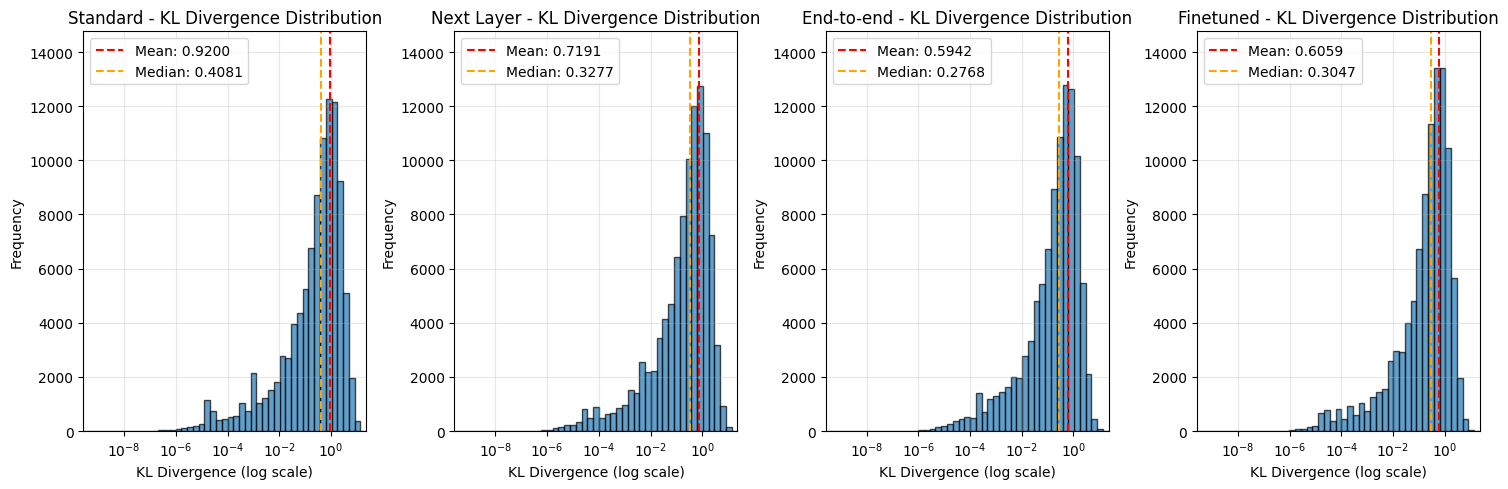

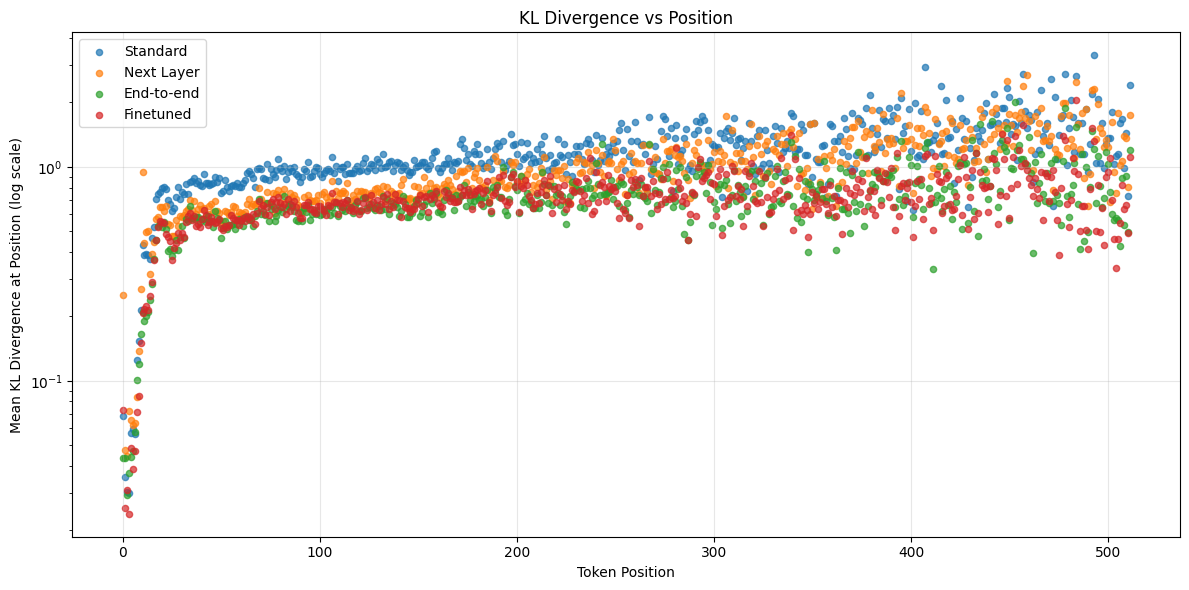

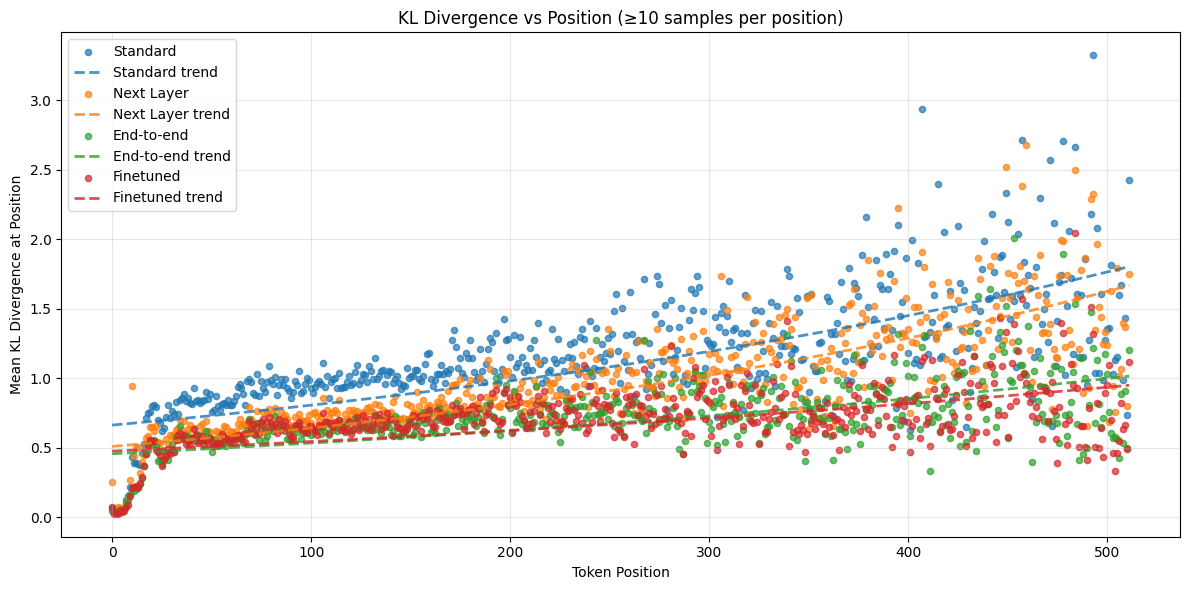

In [11]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np

# Plot histograms of KL divergence for each method
fig, axes = plt.subplots(1, len(list(replacement_evals.keys())), figsize=(15, 5))
if len(list(replacement_evals.keys())) == 1:
    axes = [axes]

# Calculate global min/max for consistent bins across all methods
all_kl_values = []
for method in replacement_evals.keys():
    kl_values = replacement_evals[method]["kl"]
    all_kl_values.extend(kl_values[kl_values > 0])

global_min = np.min(all_kl_values)
global_max = np.max(all_kl_values)
log_bins = np.logspace(np.log10(global_min), np.log10(global_max), 50)

# Calculate global y-axis limits
max_frequency = 0
for method in replacement_evals.keys():
    kl_values = replacement_evals[method]["kl"]
    counts, _ = np.histogram(kl_values, bins=log_bins)
    max_frequency = max(max_frequency, np.max(counts))

for i, method in enumerate(replacement_evals.keys()):
    ax = axes[i]
    kl_values = replacement_evals[method]["kl"]

    # Create histogram with consistent bins
    ax.hist(kl_values, bins=log_bins, alpha=0.7, edgecolor="black")
    ax.set_xscale("log")
    ax.set_xlim(global_min, global_max)
    ax.set_ylim(0, max_frequency * 1.1)
    ax.set_xlabel("KL Divergence (log scale)")
    ax.set_ylabel("Frequency")
    ax.set_title(f"{method.value} - KL Divergence Distribution")
    ax.grid(True, alpha=0.3)

    # Add statistics as text
    mean_kl = np.mean(kl_values)
    median_kl = np.median(kl_values)
    ax.axvline(mean_kl, color="red", linestyle="--", label=f"Mean: {mean_kl:.4f}")
    ax.axvline(
        median_kl, color="orange", linestyle="--", label=f"Median: {median_kl:.4f}"
    )
    ax.legend()

plt.tight_layout()
plt.show()

# Plot KL divergence vs position_id for each method on the same plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for method in replacement_evals.keys():
    kl_values = replacement_evals[method]["kl"]
    pos_ids = position_ids[method]

    # Group KL values by position_id and compute means
    pos_kl_dict = defaultdict(list)
    for kl, pos in zip(kl_values, pos_ids):
        pos_kl_dict[pos].append(kl)

    # Compute mean KL for each position
    positions = []
    mean_kls = []
    for pos in sorted(pos_kl_dict.keys()):
        positions.append(pos)
        mean_kls.append(np.mean(pos_kl_dict[pos]))

    # Create scatter plot for this method
    ax.scatter(positions, mean_kls, alpha=0.7, s=20, label=method.value)

ax.set_yscale("log")

ax.set_xlabel("Token Position")
ax.set_ylabel("Mean KL Divergence at Position (log scale)")
ax.set_title("KL Divergence vs Position")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

# Plot KL divergence vs position_id for each method on the same plot (filtered)
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for method in replacement_evals.keys():
    kl_values = replacement_evals[method]["kl"]
    pos_ids = position_ids[method]

    # Group KL values by position_id and compute means
    pos_kl_dict = defaultdict(list)
    for kl, pos in zip(kl_values, pos_ids):
        pos_kl_dict[pos].append(kl)

    # Compute mean KL for each position, filtering out positions with < 10 samples
    positions = []
    mean_kls = []
    for pos in sorted(pos_kl_dict.keys()):
        if (
            len(pos_kl_dict[pos]) >= 10
        ):  # Filter out positions with fewer than 10 samples
            positions.append(pos)
            mean_kls.append(np.mean(pos_kl_dict[pos]))

    # Create scatter plot for this method
    ax.scatter(positions, mean_kls, alpha=0.7, s=20, label=method.value)

    # Add linear regression line
    # Convert to numpy arrays for regression
    x = np.array(positions)
    y = np.log(mean_kls)  # Use log of KL values since we're on log scale

    # Perform linear regression
    coeffs = np.polyfit(x, y, 1)
    poly = np.poly1d(coeffs)

    # Generate regression line
    x_line = np.linspace(min(positions), max(positions), 100)
    y_line = np.exp(poly(x_line))  # Convert back from log space

    ax.plot(x_line, y_line, "--", alpha=0.8, linewidth=2, label=f"{method.value} trend")

ax.set_xlabel("Token Position")
ax.set_ylabel("Mean KL Divergence at Position")
ax.set_title("KL Divergence vs Position (≥10 samples per position)")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

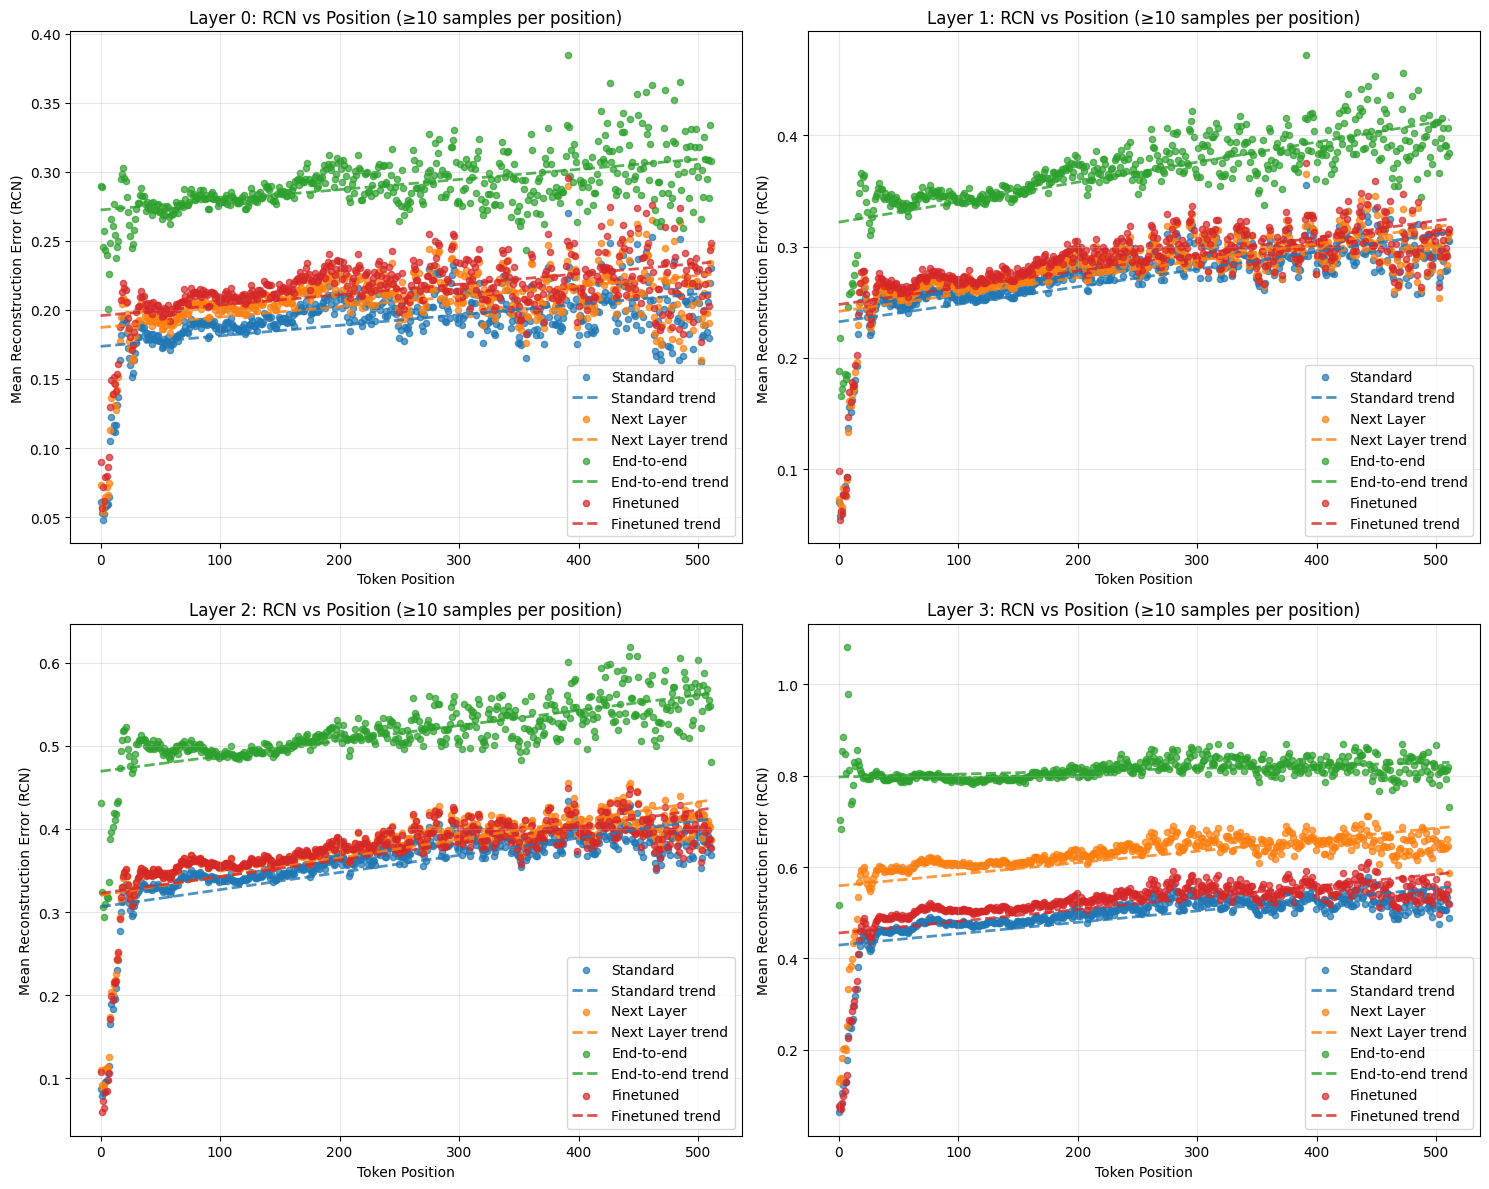

In [23]:
# Plot RCN vs Token Position for each method and layer
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for layer_idx, layer in enumerate([0, 1, 2, 3]):
    ax = axes[layer_idx]
    
    for method in TrainingMethod:
        if layer not in validation_evals[method]:
            continue
            
        # Get RCN values and position IDs for this layer
        rcn_values = validation_evals[method][layer]["rcn"].flatten()
        pos_ids = position_ids[method]
        
        # Group RCN values by position_id and compute means
        pos_rcn_dict = defaultdict(list)
        for rcn, pos in zip(rcn_values, pos_ids):
            pos_rcn_dict[pos].append(rcn)
        
        # Compute mean RCN for each position, filtering out positions with < 10 samples
        positions = []
        mean_rcns = []
        for pos in sorted(pos_rcn_dict.keys()):
            if len(pos_rcn_dict[pos]) >= 10:  # Filter out positions with fewer than 10 samples
                positions.append(pos)
                mean_rcns.append(np.mean(pos_rcn_dict[pos]))
        
        # Create scatter plot for this method
        if positions:  # Only plot if we have data
            ax.scatter(positions, mean_rcns, alpha=0.7, s=20, label=method.value)
            
            # Add linear regression line
            x = np.array(positions)
            y = np.array(mean_rcns)
            
            # Perform linear regression
            coeffs = np.polyfit(x, y, 1)
            poly = np.poly1d(coeffs)
            
            # Generate regression line
            x_line = np.linspace(min(positions), max(positions), 100)
            y_line = poly(x_line)
            
            ax.plot(x_line, y_line, "--", alpha=0.8, linewidth=2, label=f"{method.value} trend")
    
    ax.set_xlabel("Token Position")
    ax.set_ylabel("Mean Reconstruction Error (RCN)")
    ax.set_title(f"Layer {layer}: RCN vs Position (≥10 samples per position)")
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()


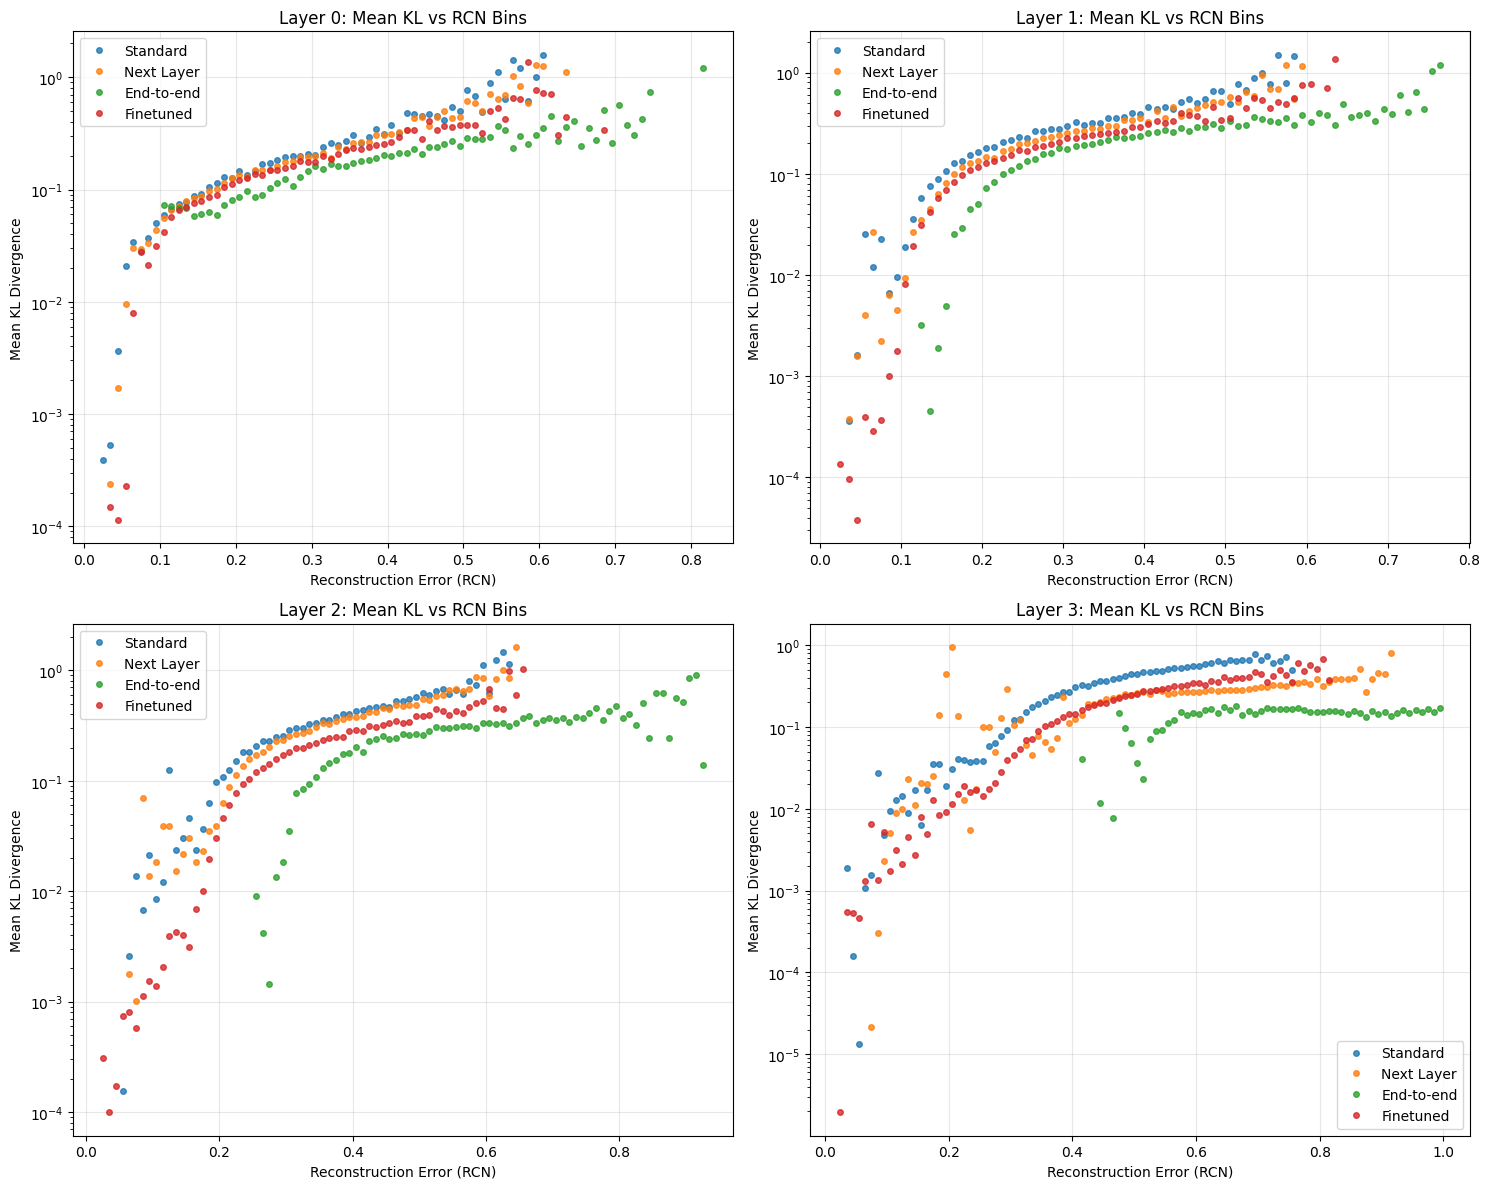

In [22]:
# Plot RCN vs KL for each method and layer with binning
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Define RCN bins
n_bins = 100
rcn_bin_edges = np.linspace(0, 1, n_bins + 1)  # Linear-spaced bins from 0 to 1

for layer_idx, layer in enumerate([0, 1, 2, 3]):
    ax = axes[layer_idx]
    
    for method in TrainingMethod:
        if layer not in validation_evals[method]:
            continue
            
        # Get RCN and KL values for this layer
        rcn_values = validation_evals[method][layer]["rcn"].flatten()
        kl_values = validation_evals[method][layer]["rep_kl"].flatten()
        
        # Bin the RCN values and compute mean KL for each bin
        bin_indices = np.digitize(rcn_values, rcn_bin_edges)
        
        bin_centers = []
        mean_kl_per_bin = []
        
        for bin_idx in range(1, len(rcn_bin_edges)):
            # Get KL values for this bin
            mask = bin_indices == bin_idx
            if np.sum(mask) > 10:  # Only include bins with sufficient samples
                bin_center = (rcn_bin_edges[bin_idx-1] + rcn_bin_edges[bin_idx]) / 2
                mean_kl = np.mean(kl_values[mask])
                
                bin_centers.append(bin_center)
                mean_kl_per_bin.append(mean_kl)
        
        # Plot the binned results
        if bin_centers:  # Only plot if we have data
            ax.plot(bin_centers, mean_kl_per_bin, 'o', alpha=0.8, 
                   label=method.value, linewidth=2, markersize=4)
    
    ax.set_ylabel("Mean KL Divergence")
    ax.set_xlabel("Reconstruction Error (RCN)")
    ax.set_title(f"Layer {layer}: Mean KL vs RCN Bins")
    ax.set_yscale("log")
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()


In [17]:
from tiny_stories_sae.validation import generate_with_replacement
from IPython.display import HTML

# Generate completions with and without SAE replacement
prompt = "Once upon a time"
sample_generations = {}

# Generate without replacement (baseline)
print("Generating baseline completion...")
baseline_tokens = generate_with_replacement(
    model, tokenizer, prompt, saes={}, do_sample=False, stream=False
)
sample_generations["Baseline"] = tokenizer.decode(baseline_tokens[0], skip_special_tokens=True)

# # Generate with each SAE method
for method in TrainingMethod:
    print(f"Generating completion with {method.value}...")
    method_tokens = generate_with_replacement(
        model,
        tokenizer,
        prompt,
        saes=saes[method],
        do_sample=False,
        stream=False,
    )
    sample_generations[method.value] = tokenizer.decode(method_tokens[0], skip_special_tokens=True)

# Display results in HTML table
html_table = """
<table border="1" style="border-collapse: collapse; width: 100%;">
<tr style="background-color: #f2f2f2;">
<th style="padding: 10px; text-align: left;">Method</th>
<th style="padding: 10px; text-align: left;">Generated Text</th>
</tr>
"""

for method_name, text in sample_generations.items():
    html_table += f"""
<tr>
<td style="padding: 10px; vertical-align: top; font-weight: bold;">{method_name}</td>
<td style="padding: 10px; font-family: monospace; white-space: pre-wrap;">{text}</td>
</tr>
"""

html_table += "</table>"

display(HTML(html_table))


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating baseline completion...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating completion with Standard...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating completion with Next Layer...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating completion with End-to-end...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating completion with Finetuned...


Method,Generated Text
Baseline,"Once upon a time, there was a little girl named Lily. She loved to play outside in the sunshine. One day, she saw a big, red apple on the ground. She picked it up and took a bite. It was so juicy and delicious! Suddenly, she heard a loud noise. It was a big, scary dog! Lily was scared and didn't know what to do. But then, she remembered the apple she had picked earlier. She took a bite and it was even more delicious than before! Lily learned that sometimes things that look scary can be delicious. She also learned that it's important to be brave and not give up. From that day on, Lily always carried an apple with her, just in case she needed to face her fears."
Standard,"Once upon a time, there was a little girl named Lily. She loved to play with her toys and her dolls. One day, Lily was playing with her dolls when she accidentally dropped her doll and got hurt. Her mom came to see what happened and asked her what happened. Lily said, ""I dropped my doll and hurt my doll."" Her mom said, ""Let's go get a band-aid to put it on it."" They went to the doctor and the doctor put a band-aid on the doll's knee. Lily was so happy that she had been able to fix her doll. She hugged her doll and said, ""I'm so happy that my doll is okay now!"" From that day on, Lily always remembered to be careful with her toys so she would never forget the band-aid she had been given."
Next Layer,"Once upon a time, there was a little girl named Lucy. She was three years old and she loved to explore. One day, she was walking in the park when she saw a big, shiny rock. She was so excited and wanted to pick it up. She asked her mom, ""Mom, can I pick it?"" Her mom said, ""Yes, but be careful. It's very heavy."" Lucy was so happy. She picked up the heavy rock and held it close. She felt like she was a princess. She wanted to show it to everyone. Suddenly, a big, mean dog came running towards her. She screamed and ran away. She was so scared that she didn't know what to do. Just then, a big, friendly dog came over and said, ""Don't worry, Lucy. I can help you. I'll help you."" The dog helped Lucy and they both laughed. Lucy was so happy that she had been brave enough to pick up the heavy, but she was also happy to have a new friend."
End-to-end,"Once upon a time, there was a little girl named Lily. She loved to play outside in the park. One day, she saw a big, shiny rock on the ground. She picked it up and showed it to her mommy. ""Look mommy, I found a pretty rock!"" she said. Her mommy smiled and said, ""That's very nice, Lily. But be careful with that rock. It's fragile."" Lily didn't understand why she had to be careful with the rock. She thought it was very pretty, but she knew it was fragile. Later that day, Lily went to the store with her mommy. She saw a big, shiny rock and wanted to take it home. She asked her mommy, ""Can I take this rock home?"" Her mommy said, ""Yes, Lily. You can take it home with you."" Lily was very happy and took the heavy rock home with her. She showed it to her friends and they all loved it. They all wanted to play with it too, but Lily said, ""No, it's fragile. We can't take it home."" The moral of the story is that sometimes things are fragile, but we can still appreciate them in life."
Finetuned,"Once upon a time, there was a little girl named Lily. She loved to play outside in the sunshine. One day, she saw a big, shiny rock on the ground. She picked it up and showed it to her mom. ""Mommy, look what I found!"" she said. Her mom smiled and said, ""That's a rock, Lily. It's very pretty. Do you want to keep it?"" Lily nodded her head and said, ""Yes, I want to keep it."" Her mom said, ""That's a very attractive rock. But you need to be careful with it. It's very special."" Lily nodded and put the rock back on the ground. She was very happy to have found something special."


# Save training runs

In [ ]:
# from tiny_stories_sae.ops import save_demo_run

# save_demo_run(
#     "/tmp/demo_runs",
#     saes,
#     training_config,
#     training_results,
#     validation_evals,
#     replacement_evals,
# )


In [ ]:
# from tiny_stories_sae.ops import load_demo_run

# loaded_saes, loaded_configs, loaded_results, loaded_validation, loaded_replacement = (
#     load_demo_run(
#         "/tmp/demo_runs",
#         # TODO: obviously we should have been persisting these in something like an SAEConfig class
#         (
#             D_MODEL,
#             D_SAE,
#         ),
#         dict(
#             device=TRAINING_DEVICE,
#             kind="topk",
#             topk=100,
#         ),
#     )
# )

In [ ]:
# saes = loaded_saes
# training_config = loaded_configs
# training_results = loaded_results